# Initial Setup

In [14]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Import Processed data as Samples

In [4]:
samples = pd.read_csv("data/processed/samples.csv", encoding="latin-1")

In [5]:
samples = samples.drop("Unnamed: 0", axis=1)
samples.head()

geo_id  year  establishments  employees  growth  exemptions_stay  \
0    1001  2005              35        157   False          35901.0   
1    1001  2006              34        175   False          36850.0   
2    1001  2007              30        109    True          37767.0   
3    1001  2008              38        116   False          39518.0   
4    1001  2009              37          0   False          40719.0   

   exemptions_in_is  exemptions_in_oos  exemptions_out_is  exemptions_out_oos  \
0            2185.0             4184.0             1883.0              3338.0   
1            2519.0             4209.0             2102.0              3545.0   
2            2394.0             4168.0             2127.0              3443.0   
3            2548.0             3863.0             2047.0              3601.0   
4            2230.0             3873.0             2118.0              3660.0   

   returns_stay  returns_in_is  returns_in_oos  returns_out_is  \
0       15062.0          951.0          1410.0           853.0   
1       15473.0         1139.0          1551.0           971.0   
2       15944.0         1072.0          1447.0          1025.0   
3       16791.0         1185.0          1458.0           989.0   
4       17385.0         1038.0          1462.0          1018.0   

   returns_out_oos  agi_stay  agi_in_is  agi_in_oos  agi_out_is  agi_out_oos  
0           1245.0  714261.0    32399.0     73510.0     26576.0      59705.0  
1           1307.0  756692.0    38883.0     82027.0     31657.0      70658.0  
2           1284.0  827611.0    37153.0     79737.0     36112.0      67092.0  
3           1398.0  901200.0    43332.0     83366.0     34063.0      69089.0  
4           1375.0  936888.0    36050.0     79697.0     34539.0      75861.0

Split off a hold-out test set of data

In [8]:
y = samples["growth"]
X = samples.drop("growth", axis=1)
X_train_labeled, X_test_labeled, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)

Remove the year and geo_id labels

In [10]:
X_train = X_train_labeled.drop(["geo_id", "year"], axis=1)
X_test = X_test_labeled.drop(["geo_id", "year"], axis=1)

# Models
## Model 1: Logistic Regression

In [101]:
# define steps and hyperparameter ranges
steps_1 = [("scaler", preprocessing.StandardScaler()),
        ("pca", PCA()),
        ("model", LogisticRegression(max_iter=10000))]
parameters_1 = {"pca__n_components":np.arange(16,18),
               "model__C": [0.01, 0.1, 1, 10, 100],
                "model__class_weight": ["balanced"],
               "model__solver": ["liblinear", "newton-cg", "sag", "lbfgs"]}

In [102]:
# create pipeline and train model
pipeline_1 = Pipeline(steps_1)
cv_1 = GridSearchCV(pipeline_1, parameters_1)
cv_1.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', LogisticRegression(C=1.0, class_weight=None, d...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([16, 17]), 'model__C': [0.01, 0.1, 1, 10, 100], 'model__class_weight': ['balanced'], 'model__solver': ['liblinear', 'newton-cg', 'sag', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
# train results
y_pred_train_1 = cv_1.predict(X_train)
confusion_matrix(y_train, y_pred_train_1)

array([[12580,  2626],
       [ 5704,  2655]], dtype=int64)

In [17]:
# score the model
y_pred_1 = cv_1.predict(X_test)
print("Best Score:", cv_1.score(X_test, y_test))
print("Best Params:", cv_1.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_1))

Best Score: 0.646976448122
Best Params: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'newton-cg', 'pca__n_components': 17}
Classification Report:
             precision    recall  f1-score   support

      False       0.69      0.82      0.75      5044
       True       0.51      0.33      0.40      2811

avg / total       0.62      0.65      0.63      7855



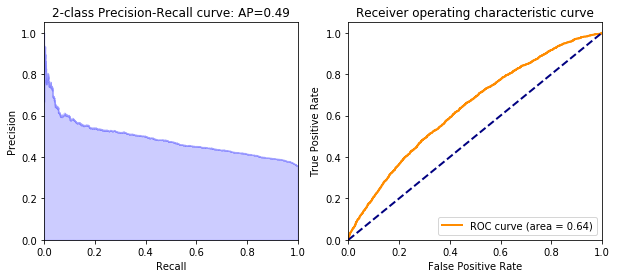

In [18]:
#more statistics to compute for graphing
y_score_1 = cv_1.decision_function(X_test)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_score_1)
average_precision_1 = average_precision_score(y_test, y_score_1)
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_score_1, pos_label=1)


#plot precision-recall curve and receiver operating characteristic
plt.figure(figsize=(10,4))
plt.subplot(121)  # 1 row, 2 columns, Plot 1
plt.step(recall_1, precision_1, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_1, precision_1, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_1))

plt.subplot(122)  # 1 row, 2 columns, Plot 2
plt.plot(fpr_1, tpr_1, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc(fpr_1, tpr_1))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

It can be seen that the model is not learning to predict the true values, the instances in which business growth is positive. Despite parameter tuning and testing with a variety of models, accuracy does not improve far beyond the %60 range.

In [20]:
y_train.head()

25697    False
7945     False
19682    False
16984    False
8360      True
Name: growth, dtype: bool

In [22]:
y_pred_train_1

array([False, False, False, ..., False, False, False], dtype=bool)

In [33]:
X_train_labeled["y_true"] = y_train
X_train_labeled["y_predicted"] = y_pred_train_1
X_train_labeled.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


geo_id  year  establishments  employees  exemptions_stay  \
25697   48093  2012               9          0          10019.0   
7945    19011  2010              12         48          21970.0   
19682   37157  2007              61        177          70822.0   
16984   31089  2009              10          0           8662.0   
8360    19095  2005               4          0          13993.0   

       exemptions_in_is  exemptions_in_oos  exemptions_out_is  \
25697             313.0              502.0              342.0   
7945              899.0              355.0              750.0   
19682            1697.0             2629.0             1743.0   
16984              99.0              348.0              127.0   
8360              423.0              307.0              327.0   

       exemptions_out_oos  returns_stay     ...       returns_in_oos  \
25697               524.0        4296.0     ...                244.0   
7945                476.0        9449.0     ...                181.0   
19682              2180.0       32101.0     ...               1238.0   
16984               270.0        3798.0     ...                151.0   
8360                330.0        6086.0     ...                159.0   

       returns_out_is  returns_out_oos   agi_stay  agi_in_is  agi_in_oos  \
25697           180.0            232.0   159361.0     3618.0      9592.0   
7945            445.0            238.0   542430.0    18466.0      6457.0   
19682           895.0           1088.0  1398501.0    28969.0     47676.0   
16984            91.0            146.0   152935.0     2264.0      5580.0   
8360            195.0            180.0   318045.0     9656.0      6222.0   

       agi_out_is  agi_out_oos  y_true  y_predicted  
25697      5030.0       7937.0   False        False  
7945      14596.0      10215.0   False        False  
19682     28614.0      40174.0   False        False  
16984      2121.0       5352.0   False        False  
8360       6030.0       8083.0    True        False  

[5 rows x 21 columns]

In [39]:
# false positives
fp = X_train_labeled[X_train_labeled["y_true"] == False]
fp = fp[fp["y_predicted"] == True]

# false negatives
fn = X_train_labeled[X_train_labeled["y_true"] == True]
fn = fn[fn["y_predicted"] == False]

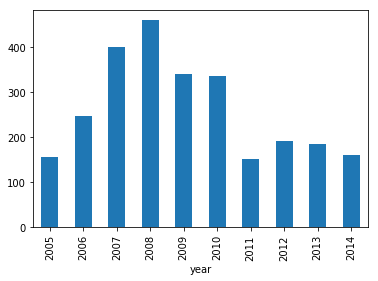

In [48]:
# false positives by year
fp.groupby("year").sum()["y_predicted"].plot(kind="bar")
plt.show()

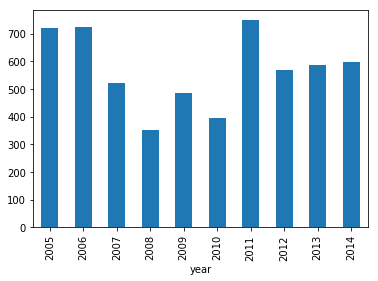

In [49]:
# false negatives by year
fn.groupby("year").sum()["y_true"].plot(kind="bar")
plt.show()

In [51]:
# Let's look by geographic area

import folium
import branca
import json

#series is a pandas series with fips code index and values for map coloring
def county_map(series, map_tiles='cartodbpositron', color="YlOrRd", caption="Legend", steps=6):
    
            
    series_max = series.quantile(.99)
    series_min = series.quantile(.01)
    

    def style_function(feature):
        map_series = series.get(int(feature['id'][-5:]), None)
        return {
            'fillOpacity': 0.5,
            'weight': 0,
            'fillColor': '#ffffff' if map_series is None 
            else getattr(branca.colormap.linear, color).scale(series_min, series_max)(map_series)
        }

    m = folium.Map(
    location=[48, -102],
    tiles=map_tiles,
    zoom_start=3
    )

    folium.TopoJson(
        open("data/maps/us_counties_20m_topo.json"),
        'objects.us_counties_20m',
        style_function=style_function
    ).add_to(m)
    
    legend = getattr(branca.colormap.linear, color).scale(series_min, series_max)
    legend.caption = caption
    m.add_child(legend)

    return m

In [55]:
fn.head()

geo_id  year  establishments  employees  exemptions_stay  \
8360    19095  2005               4          0          13993.0   
28138   50017  2013              18          0          22968.0   
11978   24011  2013              14         52          24982.0   
12890   26117  2005              29        130          48549.0   
6082    17027  2007              21          0          30212.0   

       exemptions_in_is  exemptions_in_oos  exemptions_out_is  \
8360              423.0              307.0              327.0   
28138             809.0             1298.0              774.0   
11978             908.0             1067.0              863.0   
12890            2289.0             1153.0             2087.0   
6082              745.0              577.0              820.0   

       exemptions_out_oos  returns_stay     ...       returns_in_oos  \
8360                330.0        6086.0     ...                159.0   
28138              1226.0       11564.0     ...                778.0   
11978              1120.0       11444.0     ...                505.0   
12890              1488.0       20801.0     ...                559.0   
6082                537.0       13659.0     ...                280.0   

       returns_out_is  returns_out_oos  agi_stay  agi_in_is  agi_in_oos  \
8360            195.0            180.0  318045.0     9656.0      6222.0   
28138           457.0            720.0  591869.0    16580.0     41933.0   
11978           423.0            578.0  591468.0    17991.0     17832.0   
12890          1085.0            734.0  835584.0    36561.0     17010.0   
6082            456.0            307.0  729016.0    15270.0     12642.0   

       agi_out_is  agi_out_oos  y_true  y_predicted  
8360       6030.0       8083.0    True        False  
28138     16116.0      27478.0    True        False  
11978     15865.0      23473.0    True        False  
12890     30566.0      22398.0    True        False  
6082      15984.0      11224.0    True        False  

[5 rows x 21 columns]

In [104]:
# counties that are falsely predicted not to grow
county_map(fn["y_predicted"], color="RdGy")

In [64]:
# counties that are falsely predicted to grow
county_map(fp["y_predicted"], color="RdGy")

In [106]:
incorrect = pd.concat([fp, fn])

In [107]:
county_map(incorrect["year"])

In [80]:
subsamples = samples[(samples["year"] != 2007) & (samples["year"] != 2008)]

In [81]:
subsamples.head()

geo_id  year  establishments  employees  growth  exemptions_stay  \
0    1001  2005              35        157   False          35901.0   
1    1001  2006              34        175   False          36850.0   
4    1001  2009              37          0   False          40719.0   
5    1001  2010              37        125   False          40099.0   
6    1001  2011              34        115   False          40643.0   

   exemptions_in_is  exemptions_in_oos  exemptions_out_is  exemptions_out_oos  \
0            2185.0             4184.0             1883.0              3338.0   
1            2519.0             4209.0             2102.0              3545.0   
4            2230.0             3873.0             2118.0              3660.0   
5            2225.0             3544.0             1925.0              3018.0   
6            2331.0             3916.0             2080.0              3479.0   

   returns_stay  returns_in_is  returns_in_oos  returns_out_is  \
0       15062.0          951.0          1410.0           853.0   
1       15473.0         1139.0          1551.0           971.0   
4       17385.0         1038.0          1462.0          1018.0   
5       17015.0         1023.0          1353.0           931.0   
6       17278.0         1115.0          1470.0          1045.0   

   returns_out_oos  agi_stay  agi_in_is  agi_in_oos  agi_out_is  agi_out_oos  
0           1245.0  714261.0    32399.0     73510.0     26576.0      59705.0  
1           1307.0  756692.0    38883.0     82027.0     31657.0      70658.0  
4           1375.0  936888.0    36050.0     79697.0     34539.0      75861.0  
5           1156.0  902131.0    35917.0     68159.0     30103.0      60508.0  
6           1418.0  939506.0    36061.0     81774.0     29898.0      74759.0

In [82]:
y_sub = subsamples["growth"]
X_sub = subsamples.drop(["geo_id", "year", "growth"], axis=1)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.25, random_state=36)

In [97]:
# define steps and hyperparameter ranges
steps_1_sub = [("scaler", preprocessing.StandardScaler()),
        ("pca", PCA()),
        ("model", LogisticRegression(max_iter=10000))]
parameters_1_sub = {"pca__n_components":np.arange(16,18),
               "model__C": [0.01, 0.1, 1, 10, 100],
                "model__class_weight": ["balanced"],
               "model__solver": ["liblinear", "newton-cg", "sag", "lbfgs"]}

In [98]:
# create pipeline and train model
pipeline_1_sub = Pipeline(steps_1_sub)
cv_1_sub = GridSearchCV(pipeline_1_sub, parameters_1_sub)
cv_1_sub.fit(X_train_sub, y_train_sub)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', LogisticRegression(C=1.0, class_weight=None, d...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([16, 17]), 'model__C': [0.01, 0.1, 1, 10, 100], 'model__class_weight': ['balanced'], 'model__solver': ['liblinear', 'newton-cg', 'sag', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [99]:
# train results
y_pred_train_1_sub = cv_1_sub.predict(X_train_sub)
confusion_matrix(y_train_sub, y_pred_train_1_sub)

array([[9768, 1802],
       [4765, 2517]], dtype=int64)

In [100]:
# score the model
y_pred_1_sub = cv_1_sub.predict(X_test_sub)
print("Best Score:", cv_1_sub.score(X_test_sub, y_test_sub))
print("Best Params:", cv_1_sub.best_params_)
print("Classification Report:")
print(classification_report(y_test_sub, y_pred_1_sub))

Best Score: 0.648949713558
Best Params: {'model__C': 1, 'model__class_weight': 'balanced', 'model__solver': 'liblinear', 'pca__n_components': 16}
Classification Report:
             precision    recall  f1-score   support

      False       0.67      0.85      0.75      3829
       True       0.59      0.34      0.43      2455

avg / total       0.64      0.65      0.62      6284



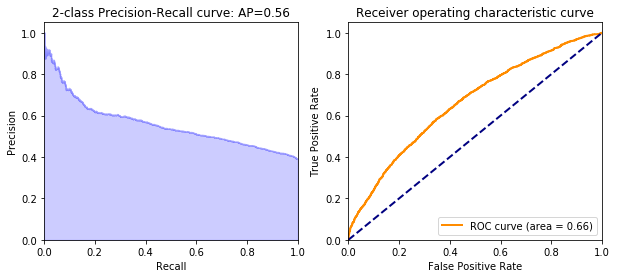

In [103]:
#more statistics to compute for graphing
y_score_1_sub = cv_1_sub.decision_function(X_test_sub)
precision_1_sub, recall_1_sub, _ = precision_recall_curve(y_test_sub, y_score_1_sub)
average_precision_1_sub = average_precision_score(y_test_sub, y_score_1_sub)
fpr_1_sub, tpr_1_sub, thresholds_1_sub = roc_curve(y_test_sub, y_score_1_sub, pos_label=1)


#plot precision-recall curve and receiver operating characteristic
plt.figure(figsize=(10,4))
plt.subplot(121)  # 1 row, 2 columns, Plot 1
plt.step(recall_1_sub, precision_1_sub, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_1_sub, precision_1_sub, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_1_sub))

plt.subplot(122)  # 1 row, 2 columns, Plot 2
plt.plot(fpr_1_sub, tpr_1_sub, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc(fpr_1_sub, tpr_1_sub))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

## Model 2: Nearest Neighbors

In [10]:
# define steps and hyperparameter ranges
steps_2 = [("scaler", preprocessing.StandardScaler()),
        ("pca", PCA()),
        ("model", KNeighborsClassifier())]
parameters_2 = {"pca__n_components":np.arange(1,18),
             "model__n_neighbors":np.arange(1,10)}

In [11]:
# create pipeline and train model
pipeline_2 = Pipeline(steps_2)
cv_2 = GridSearchCV(pipeline_2, parameters_2)
cv_2.fit(X_train, y_train)
y_pred_2 = cv_2.predict(X_test)

In [12]:
#score the model
print("Best Score:", cv_2.score(X_test, y_test))
print("Best Params:", cv_2.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_2))

Best Score: 0.624188415022
Best Params: {'model__n_neighbors': 8, 'pca__n_components': 4}
Classification Report:
             precision    recall  f1-score   support

      False       0.66      0.87      0.75      5044
       True       0.44      0.18      0.26      2811

avg / total       0.58      0.62      0.57      7855



## Model 3: Naive Bayes

In [13]:
# define steps and hyperparameter ranges
steps_3 = [("scaler", preprocessing.StandardScaler()),
        ("pca", PCA()),
        ("model", GaussianNB())]
parameters_3 = {"pca__n_components":np.arange(1,18)}

In [14]:
# create pipeline and train model
pipeline_3 = Pipeline(steps_3)
cv_3 = GridSearchCV(pipeline_3, parameters_3)
cv_3.fit(X_train, y_train)
y_pred_3 = cv_3.predict(X_test)

In [15]:
#score the model
print("Best Score:", cv_3.score(X_test, y_test))
print("Best Params:", cv_3.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_3))

Best Score: 0.64455760662
Best Params: {'pca__n_components': 11}
Classification Report:
             precision    recall  f1-score   support

      False       0.65      0.95      0.77      5044
       True       0.52      0.11      0.17      2811

avg / total       0.61      0.64      0.56      7855



## Model 4: Random Forest

In [16]:
# define steps and hyperparameter ranges
steps_4 = [("scaler", preprocessing.StandardScaler()),
        ("pca", PCA()),
        ("model", RandomForestClassifier())]
parameters_4 = {"pca__n_components":np.arange(10,18),
             "model__n_estimators":[50],
             "model__max_features":["sqrt", "log2"],
             "model__min_samples_leaf":[20, 30, 40]}

In [17]:
# create pipeline and train model
pipeline_4 = Pipeline(steps_4)
cv_4 = GridSearchCV(pipeline_4, parameters_4)
cv_4.fit(X_train, y_train)
y_pred_4 = cv_4.predict(X_test)

In [18]:
#score the model
print("Best Score:", cv_4.score(X_test, y_test))
print("Best Params:", cv_4.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_4))

Best Score: 0.660343730108
Best Params: {'model__max_features': 'sqrt', 'model__min_samples_leaf': 40, 'model__n_estimators': 50, 'pca__n_components': 16}
Classification Report:
             precision    recall  f1-score   support

      False       0.67      0.92      0.78      5044
       True       0.58      0.19      0.28      2811

avg / total       0.64      0.66      0.60      7855



## Model 5: Support Vector Machine

In [19]:
# define steps and hyperparameter ranges
steps_5 = [("scaler", preprocessing.StandardScaler()),
        ("pca", PCA()),
        ("model", SVC())]
parameters_5 = {"pca__n_components":np.arange(10,18),
             "model__C":[0.01, 0.1, 1, 10]}

In [20]:
# create pipeline and train model
pipeline_5 = Pipeline(steps_5)
cv_5 = GridSearchCV(pipeline_5, parameters_5)
cv_5.fit(X_train, y_train)
y_pred_5 = cv_5.predict(X_test)

In [21]:
#score the model
print("Best Score:", cv_5.score(X_test, y_test))
print("Best Params:", cv_5.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_5))

Best Score: 0.655378739656
Best Params: {'model__C': 10, 'pca__n_components': 17}
Classification Report:
             precision    recall  f1-score   support

      False       0.66      0.97      0.78      5044
       True       0.62      0.10      0.17      2811

avg / total       0.64      0.66      0.56      7855



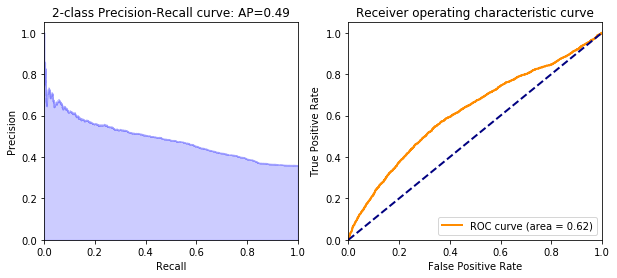

In [22]:
#more statistics to compute for graphing
y_score_5 = cv_5.decision_function(X_test)
precision_5, recall_5, _ = precision_recall_curve(y_test, y_score_5)
average_precision_5 = average_precision_score(y_test, y_score_5)
fpr_5, tpr_5, thresholds_5 = roc_curve(y_test, y_score_5, pos_label=1)


#plot precision-recall curve and receiver operating characteristic
plt.figure(figsize=(10,4))
plt.subplot(121)  # 1 row, 2 columns, Plot 1
plt.step(recall_5, precision_5, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_5, precision_5, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_5))

plt.subplot(122)  # 1 row, 2 columns, Plot 2
plt.plot(fpr_5, tpr_5, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc(fpr_5, tpr_5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Intepretation